In [1]:
!pip install keract

In [2]:
!git clone https://github.com/DatenBiene/Medical_Time_Series_Classification.git

Cloning into 'Medical_Time_Series_Classification'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 356 (delta 49), reused 70 (delta 20), pack-reused 241
Receiving objects: 100% (356/356), 24.77 MiB | 18.35 MiB/s, done.
Resolving deltas: 100% (180/180), done.


In [0]:
import os 
os.chdir('/content/Medical_Time_Series_Classification')

# Imports

In [0]:
%load_ext autoreload
%autoreload 2

In [5]:
#import keract
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score
import keras
import tensorflow as tf
import matplotlib.font_manager
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from utils.evaluation import *
from utils.utils import read_dataset,split_dataset
%matplotlib inline

Using TensorFlow backend.


# 1. Data importation and visualization

In [0]:
X_train,y_train,X_val,y_val,X_test,y_test = np.load('data/ECG5000/ECG5000_full.npy',allow_pickle=True)

data = np.concatenate([X_train,X_val,X_test])
labels = np.concatenate([y_train,y_val,y_test])

In [0]:
y_train_1H = np.zeros((len(y_train),5))
y_val_1H = np.zeros((len(y_val),5))
y_test_1H = np.zeros((len(y_test),5))

for k in range(len(y_train)):
  y_train_1H[k,y_train[k]-1] += 1

for k in range(len(y_val)):
  y_val_1H[k,y_val[k]-1] += 1

for k in range(len(y_test)):
  y_test_1H[k,y_test[k]-1] += 1

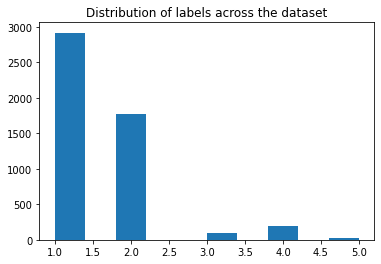

In [8]:
plt.hist(labels)
plt.title('Distribution of labels across the dataset')
plt.show()

In [9]:
unique_labels,props = np.unique(labels,return_counts=True)
df_props = pd.DataFrame([],columns=['proportion'],index = unique_labels)
df_props.index.name='label'
df_props['proportion'] = props/np.sum(props)
df_props

,proportion
label,
1,0.5838
2,0.3534
3,0.0192
4,0.0388
5,0.0048


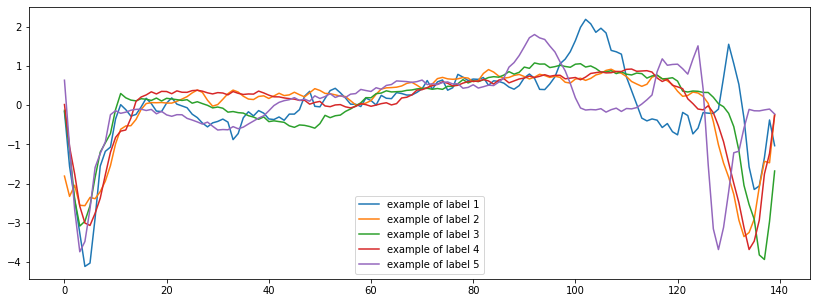

In [10]:
fig = plt.figure(figsize=(14,5))
for c in set(labels):
    spe_ecg = data[labels==c][0]
    plt.plot(spe_ecg,label='example of label '+str(c))

plt.legend()
plt.show()

# 2. Testing models

In [0]:
%matplotlib inline

## 2.1 Test MLP

In [0]:
from models.mlp import Classifier_MLP

In [13]:
mlp = Classifier_MLP(output_directory='outputs/output_mlp/',input_shape=(X_train.shape[1],),
                     nb_classes = 5,verbose=True,
                     hidden_layers_size=(70,35),min_lr=0.05)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 140)               0         
_________________________________________________________________
dropout (Dropout)            (None, 140)               0         
_________________________________________________________________
dense (Dense)                (None, 70)                9870      
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 35)                2485      
_________________________________________________________________
dropout_2 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1

Epoch 1/100
125/125 [==============================] - 0s 4ms/step - loss: 1.3525 - accuracy: 0.4327 - val_loss: 1.2891 - val_accuracy: 0.5740 - lr: 0.0010
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 1.3376 - accuracy: 0.4577 - val_loss: 1.2695 - val_accuracy: 0.6180 - lr: 0.0010
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 1.3181 - accuracy: 0.4690 - val_loss: 1.2499 - val_accuracy: 0.6620 - lr: 0.0010
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 1.2860 - accuracy: 0.4980 - val_loss: 1.2300 - val_accuracy: 0.6920 - lr: 0.0010
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 1.2711 - accuracy: 0.5120 - val_loss: 1.2103 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 1.2608 - accuracy: 0.5245 - val_loss: 1.1907 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 7/100
125/125 [==============================] - 0s 2ms/st

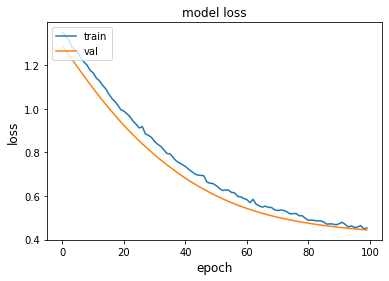

In [14]:
hist = mlp.fit(X_train,y_train_1H,X_val,y_val_1H,y_val,batch_size=32,nb_epochs=100)

Let's evaluate our predictions on the validation set: 

In [15]:
mlp = tf.keras.models.load_model('outputs/output_mlp/best_model.hdf5')
y_pred = mlp.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)+1
evaluate(y_test,y_pred)

,accuracy,recall,precision,f1-score
0,0.918,0.392261,0.363461,0.376924


Let's be more precise on each class. The following scores are computed considering each label against all the others.

In [16]:
get_binary_metrics(y_val,y_pred)

,recall,precision,f1-score
1,0.591078,0.537162,0.562832
2,0.417112,0.382353,0.398977
3,0,0,0
4,0,0,0
5,0,0,0


In [17]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test,y_pred)
print(mat)

[[284   8   0   0   0]
 [  2 175   0   0   0]
 [  2   8   0   0   0]
 [  7  12   0   0   0]
 [  1   1   0   0   0]]


## 2.2 Test ResNet

In [0]:
from models.resnet import Classifier_RESNET

In [0]:
#resnet requires a different shape since it is based on convolutional layers
X_train_1D = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_val_1D = X_val.reshape(X_val.shape[0],X_val.shape[1],1)
X_test_1D = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [20]:
resnet = Classifier_RESNET('outputs/output_resnet/',input_shape=(data.shape[1],1),nb_classes=5,verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 140, 64)      384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 140, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 140, 64)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

Epoch 1/5
250/250 [==============================] - 3s 11ms/step - loss: 0.2855 - accuracy: 0.9237 - val_loss: 0.6019 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 2/5
250/250 [==============================] - 2s 9ms/step - loss: 0.2259 - accuracy: 0.9360 - val_loss: 0.3230 - val_accuracy: 0.9080 - lr: 0.0010
Epoch 3/5
250/250 [==============================] - 2s 9ms/step - loss: 0.1954 - accuracy: 0.9477 - val_loss: 0.3259 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 4/5
250/250 [==============================] - 2s 9ms/step - loss: 0.1840 - accuracy: 0.9473 - val_loss: 0.2910 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 5/5
250/250 [==============================] - 2s 9ms/step - loss: 0.1756 - accuracy: 0.9505 - val_loss: 0.3003 - val_accuracy: 0.9140 - lr: 0.0010


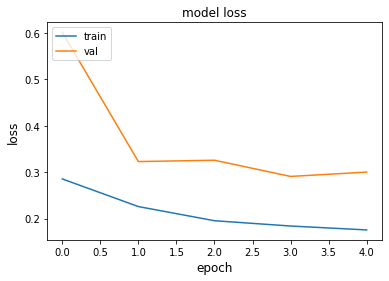

In [21]:
%matplotlib inline
hist = resnet.fit(X_train_1D,y_train_1H,X_val_1D,y_val_1H,y_val,batch_size=16,nb_epochs=5)

In [22]:
resnet = tf.keras.models.load_model('outputs/output_resnet/best_model.hdf5')
y_pred = resnet.predict(X_test_1D)
y_pred = np.argmax(y_pred,axis=1)+1
evaluate(y_test,y_pred)

,accuracy,recall,precision,f1-score
0,0.952,0.625167,0.658121,0.602354


In [23]:
get_binary_metrics(y_test,y_pred)

,recall,precision,f1-score
1,0.996575,0.983108,0.989796
2,0.966102,0.944751,0.955307
3,0.9,0.529412,0.666667
4,0.263158,0.833333,0.4
5,0,0,0


In [24]:
mat = confusion_matrix(y_test,y_pred)
print(mat)

[[291   0   1   0   0]
 [  1 171   4   1   0]
 [  1   0   9   0   0]
 [  2  10   2   5   0]
 [  1   0   1   0   0]]


## 2.3 Test 1D-CNN

In [0]:
from models.CNN_1D import Classifier_1DCNN

In [26]:
CNN_1D = Classifier_1DCNN('outputs/output_1DCNN/', nb_classes=5, n_conv_block=3, n_filters=[2,4,8],
                           kern_size=[32,32,32], n_stride=[1,1,1], input_shape=(data.shape[1],1), 
                           add_FC=False, n_unit_FC=1, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 140, 2)            66        
_________________________________________________________________
batch_normalization (BatchNo (None, 140, 2)            8         
_________________________________________________________________
activation (Activation)      (None, 140, 2)            0         
_________________________________________________________________
dropout (Dropout)            (None, 140, 2)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 140, 2)            130       
_________________________________________________________________
batch_normalization_1 (Batch (None, 140, 2)            8         
_________________________________________________________________
activation_1 (Activation)    (None, 140, 2)            0

Epoch 1/30
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
125/125 [==============================] - 1s 11ms/step - loss: 0.3281 - accuracy: 0.9133 - val_loss: 0.5494 - val_accuracy: 0.9100
Epoch 2/30
125/125 [==============================] - 1s 9ms/step - loss: 0.2391 - accuracy: 0.9385 - val_loss: 0.3170 - val_accuracy: 0.9000
Epoch 3/30
125/125 [==============================] - 1s 9ms/step - loss: 0.2140 - accuracy: 0.9425 - val_loss: 0.3170 - val_accuracy: 0.9140
Epoch 4/30
125/125 [==============================] - 1s 9ms/step - loss: 0.2037 - accuracy: 0.9442 - val_loss: 0.2935 - val_accuracy: 0.9080
Epoch 5/30
125/125 [==============================] - 1s 9ms/step - loss: 0.1942 - accuracy: 0.9475 - val_loss: 0.2910 - val_accuracy: 0.9140
Epoch 6/30
125/125 [==============================] - 1s 9ms/step - loss: 0.1791 - accuracy: 0.9505 - val_loss: 0.2638 - val_accuracy: 0.9120
Epoch 7/30
125/125 [==============================] - 1s 9ms/step 

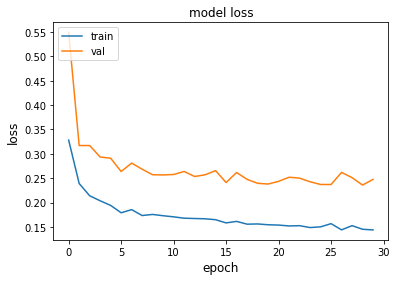

CPU times: user 36.5 s, sys: 1.5 s, total: 38 s
Wall time: 36.8 s


In [27]:
%%time
%matplotlib inline
hist = CNN_1D.fit(X_train_1D,y_train_1H,X_val_1D,y_val_1H,y_val,batch_size=32,nb_epochs=30)

In [28]:
CNN_1D = tf.keras.models.load_model('outputs/output_1DCNN/best_model.hdf5')
y_pred = CNN_1D.predict(X_test_1D)
y_pred = np.argmax(y_pred,axis=1)+1
evaluate(y_test,y_pred)

,accuracy,recall,precision,f1-score
0,0.96,0.630132,0.70154,0.634616


In [29]:
get_binary_metrics(y_test,y_pred)

,recall,precision,f1-score
1,0.993151,0.993151,0.993151
2,0.99435,0.931217,0.961749
3,0.9,0.75,0.818182
4,0.263158,0.833333,0.4
5,0,0,0


In [30]:
mat = confusion_matrix(y_test,y_pred)
print(mat)

[[290   1   0   0   1]
 [  0 176   0   1   0]
 [  1   0   9   0   0]
 [  1  12   1   5   0]
 [  0   0   2   0   0]]


#3. Interpreting models

In [0]:
from interpretation.cam import *

In [0]:
not_normal = []
for i in range(len(y_pred)):
    if not y_pred[i]==0: 
        not_normal.append(i)

## 3.1 ResNet model

In [33]:
resnet_model = tf.keras.models.load_model('outputs/output_resnet/best_model.hdf5')

In [34]:
display_conv_activations(resnet_model,X_val_1D[not_normal[0]])

AttributeError: ignored